In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import io
import os
from pathlib import Path
import select
from shutil import rmtree
import subprocess as sp
import sys
from typing import Dict, Tuple, Optional, IO
import mido
import pprint
from abc import ABC
import os
import json
from termcolor import colored
from typing import List
import pydub
from pydub import AudioSegment
from tqdm import tqdm
from mido import MidiFile
import pprint
from collections import defaultdict

In [5]:

class Visualizer(ABC):
    def plot(self):
        pass


class AudioSeparator:
    def __init__(self, in_path, out_path, model="mdx_q", extensions=["mp3", "wav", "ogg", "flac"], two_stems=None, mp3=True, mp3_rate=320, float32=False, int24=False):
        self.in_path = in_path
        self.out_path = out_path
        self.model = model
        self.extensions = extensions
        self.two_stems = two_stems
        self.mp3 = mp3
        self.mp3_rate = mp3_rate
        self.float32 = float32
        self.int24 = int24
        self.stems = ['bass.mp3', 'drums.mp3', 'vocals.mp3', 'other.mp3']

    def separate(self, inp=None, outp=None):
        inp = inp or self.in_path
        outp = outp or self.out_path

        cmd = ["python3", "-m", "demucs.separate", "-o", str(outp), "-n", self.model]
        if self.mp3:
            cmd += ["--mp3", f"--mp3-bitrate={self.mp3_rate}"]
        if self.float32:
            cmd += ["--float32"]
        if self.int24:
            cmd += ["--int24"]
        if self.two_stems is not None:
            cmd += [f"--two-stems={self.two_stems}"]

        files = [str(f) for f in self._find_files(inp)]
        if not files:
            print(f"No valid audio files in {self.in_path}")
            return

        print("Going to separate the files:")
        print('\n'.join(files))
        print("With command: ", " ".join(cmd))
        p = sp.Popen(cmd + files, stdout=sp.PIPE, stderr=sp.PIPE)
        self._copy_process_streams(p)
        p.wait()
        if p.returncode != 0:
            print("Command failed, something went wrong.")

    def _is_separated(self, outp):
        return all(os.path.exists(Path(outp, stem)) for stem in self.stems)

    def _find_files(self, in_path):
        out = []
        in_path = Path(in_path)
        if in_path.is_dir():
            for file in in_path.iterdir():
                if file.suffix.lower().lstrip(".") in self.extensions:
                    out.append(file)
        else:
            if in_path.suffix.lower().lstrip(".") in self.extensions:
                out.append(in_path)
        return out


    def _copy_process_streams(self, process: sp.Popen):
        def _raw(stream: Optional[IO[bytes]]) -> IO[bytes]:
            assert stream is not None
            if isinstance(stream, io.BufferedIOBase):
                stream = stream.raw
            return stream

        p_stdout, p_stderr = _raw(process.stdout), _raw(process.stderr)
        stream_by_fd: Dict[int, Tuple[IO[bytes], io.StringIO, IO[str]]] = {
                p_stdout.fileno(): (p_stdout, sys.stdout),
                p_stderr.fileno(): (p_stderr, sys.stderr),
                }
        fds = list(stream_by_fd.keys())

        while fds:
            ready, _, _ = select.select(fds, [], [])
            for fd in ready:
                p_stream, std = stream_by_fd[fd]
                raw_buf = p_stream.read(2 ** 16)
                if not raw_buf:
                    fds.remove(fd)
                    continue
                buf = raw_buf.decode()
                std.write(buf)
                std.flush()


class RMS(Visualizer):
    def __init__(self, in_path, demucs_in_path, out_path, threshold = 0.8, sr=44100, frame_length=65000, hop_length=16250, n_ignore=10):
        self.in_path = in_path
        self.sr = sr
        self.frame_length = frame_length
        self.hop_length = hop_length
        self.n_ignore = n_ignore
        self.demucs_in_path = demucs_in_path
        self.threshold = threshold

    def plot(self):
        rms, times = self._compute_rms(self.in_path)

        rms_data = []
        rms_data.append(self._compute_splited_rms(self.in_path, self.demucs_in_path + "/bass.mp3")[0])
        rms_data.append(self._compute_splited_rms(self.in_path, self.demucs_in_path + "/drums.mp3")[0])
        rms_data.append(self._compute_splited_rms(self.in_path, self.demucs_in_path + "/other.mp3")[0])
        rms_data.append(self._compute_splited_rms(self.in_path, self.demucs_in_path + "/vocals.mp3")[0])

        labels = ["bass", "drums", "vocals", "other"]

        self._plot_rms_with_color(times, rms_data, rms, labels)

    def compute_rms(self, file):
        y, _ = librosa.load(file, sr=self.sr, mono=True)
        rms = librosa.feature.rms(y=y, frame_length=self.frame_length, hop_length=self.hop_length)[0]
        rms /= np.max(rms)
        times = np.floor(librosa.times_like(rms, hop_length=self.hop_length, sr=self.sr))

        return rms, times

    def _compute_splited_rms(self, file, s_file):
        s_y, s_sr = librosa.load(s_file, sr=44100, mono=True)
        y, _ = librosa.load(file, sr=44100, mono=True)
        s_rms = librosa.feature.rms(y=s_y, frame_length=self.frame_length, hop_length=self.hop_length)[0]
        rms = librosa.feature.rms(y=y, frame_length=self.frame_length, hop_length=self.hop_length)[0]
        s_rms /= np.max(rms)
        times = np.floor(librosa.times_like(s_rms, hop_length=self.hop_length, sr=s_sr))

        return s_rms, times

    def _plot_rms_with_color(self, times, rms_data, rms, labels):
        plt.figure(figsize=(15, 5))

        plt.plot(rms, color="black", lw=2.0)

        plt.ylabel("RMS")
        plt.xlabel("time")

        red_count = 0
        for i in range(len(times)):
            if rms[i] > self.threshold:
                red_count += 1
                plt.vlines(i, 0, 1, color="red", alpha=0.4)
            else:
                plt.vlines(i, 0, 1, color="green", alpha=0.4)
                if red_count == 0:
                    plt.vlines(i, 0, 1, color="yellow", alpha=0.4)

        red_count_2 = 0
        for i in range(len(times)):
            if red_count == red_count_2:
                plt.vlines(i, 0, 1, color="blue", alpha=0.4)
            if rms[i] > self.threshold:
                red_count_2 += 1

        colors = ["blue", "magenta", "yellow", "green"]
        for rms, label, color in zip(rms_data, labels, colors):
            plt.plot(rms, label=label, color=color ,lw=2, alpha=1)

        plt.legend()
        plt.show()


class Drum(Visualizer):
    def __init__(self, in_path):
        self.in_path = in_path
        self.drum_mapping = {
                35: 'Acoustic Bass Drum',
                36: 'Bass Drum 1',
                37: 'Side Stick',
                38: 'Acoustic Snare',
                39: 'Hand Clap',
                40: 'Electric Snare',
                41: 'Low Floor Tom',
                42: 'Closed Hi-Hat',
                43: 'High Floor Tom',
                44: 'Pedal Hi-Hat',
                45: 'Low Tom',
                46: 'Open Hi-Hat',
                47: 'Low-Mid Tom',
                48: 'Hi-Mid Tom',
                49: 'Crash Cymbal 1',
                50: 'High Tom',
                51: 'Ride Cymbal 1',
                52: 'Chinese Cymbal',
                53: 'Ride Bell',
                54: 'Tambourine',
                55: 'Splash Cymbal',
                56: 'Cowbell',
                57: 'Crash Cymbal 2',
                58: 'Vibraslap',
                59: 'Ride Cymbal 2',
                60: 'Hi Bongo',
                61: 'Low Bongo',
                62: 'Mute Hi Conga',
                63: 'Open Hi Conga',
                64: 'Low Conga',
                65: 'High Timbale',
                66: 'Low Timbale',
                67: 'High Agogo',
                68: 'Low Agogo',
                69: 'Cabasa',
                70: 'Maracas',
                71: 'Short Whistle',
                72: 'Long Whistle',
                73: 'Short Guiro',
                74: 'Long Guiro',
                75: 'Claves',
                76: 'Hi Wood Block',
                77: 'Low Wood Block',
                78: 'Mute Cuica',
                79: 'Open Cuica',
                80: 'Mute Triangle',
                81: 'Open Triangle'
                }

    def get_drum_events(self):
        mid = mido.MidiFile(self.in_path)
        events = self._extract_events(mid)
        return events

    def _extract_events(self, mid):
        events = {}
        drum_counter = 0
        time = 0
        tempo = mido.bpm2tempo(120)

        for track in mid.tracks:
            for msg in track:
                time += mido.tick2second(msg.time, mid.ticks_per_beat, tempo)
                new_tempo = self._extract_tempo(msg)
                if new_tempo is not None:
                    tempo = new_tempo
                elif self._is_drum_part(msg):
                    if msg.note not in events:
                        events[msg.note] = {'name': self.drum_mapping[msg.note], 'id': drum_counter, 'times': []}
                        drum_counter += 1
                    events[msg.note]['times'].append(time)
        return events

    def _plot_events(self, events):
        plt.figure(figsize=(15, 5))
        for drum_note, event in events.items():
            plt.eventplot(event['times'], orientation='horizontal', linelengths=0.08, lineoffsets=event['id'])
        plt.yticks([event['id'] for event in events.values()], [event['name'] for event in events.values()])
        plt.xlabel('Time')
        plt.ylabel('Drum elements')
        plt.title('Drum elements over time')
        plt.grid(True)
        plt.show()

    def _extract_tempo(self, message):
        if message.type == 'set_tempo':
            return message.tempo
        return None

    def _is_drum_part(self, message):
        return message.type == 'note_on' and message.note in self.drum_mapping

    def detect_pattern_changes(self, events):
        all_event_times = [time for event in events.values() for time in event['times']]
        avg_interval, std_deviation = self._calculate_similarity(all_event_times)
        pattern_changes = self._find_unique_integers(all_event_times, avg_interval, std_deviation)
        return pattern_changes

    def _find_unique_integers(self, event_times, avg_interval, std_deviation):
        unique_integers = []

        similarity_scores = []
        prev_change_time = None

        for i in range(1, len(event_times) - 1):
            prev_interval = event_times[i] - event_times[i - 1]
            next_interval = event_times[i + 1] - event_times[i]
            similarity_score = abs(prev_interval - avg_interval) + abs(next_interval - avg_interval)
            similarity_scores.append(similarity_score)

        threshold = std_deviation
        for i, similarity_score in enumerate(similarity_scores):
            if similarity_score > threshold:
                change_time = int(round(event_times[i]))
                if prev_change_time is None or change_time != prev_change_time:
                    unique_integers.append(change_time)
                prev_change_time = change_time

        for i in range(1, len(event_times) - 1):
            interval = event_times[i] - event_times[i - 1]

            if abs(interval - avg_interval) > std_deviation:
                unique_integers.append(int(round(event_times[i])))

        return list(set(unique_integers))

    def _calculate_similarity(self, times):
        intervals = np.diff(times)
        avg_interval = np.mean(intervals)
        std_deviation = np.std(intervals)
        return avg_interval, std_deviation

    def _plot_pattern_changes(self, events, pattern_changes):
        plt.figure(figsize=(15, 5))
        for drum_note, event in events.items():
            plt.eventplot(event['times'], orientation='horizontal', linelengths=0.08, lineoffsets=event['id'])
        plt.yticks([event['id'] for event in events.values()], [event['name'] for event in events.values()])
        plt.xlabel('Time')
        plt.ylabel('Drum elements')
        plt.title('Drum elements over time')
        plt.grid(True)

        for change_time in pattern_changes:
            plt.axvline(x=change_time, color='red', linestyle='--')

        plt.show()

    def plot_drum_with_pattern_changes(self, song_name, events, pattern_changes):
        plt.figure(figsize=(15, 5))
        for drum_note, event in events.items():
            plt.eventplot(event['times'], orientation='horizontal', linelengths=0.08, lineoffsets=event['id'])
        plt.yticks([event['id'] for event in events.values()], [event['name'] for event in events.values()])
        plt.xlabel('Time')
        plt.ylabel('Drum elements')
        plt.title(f'Drum elements over time - {song_name}')
        plt.grid(True)

        for change_time in pattern_changes:
            if change_time <= max(max(event['times']) for event in events.values()):
                plt.axvline(x=change_time, color='red', linestyle='--')

        plt.show()

    def plot_drum_with_pattern_and_sections(self, song_name, events, pattern_changes, section_data):
        plt.figure(figsize=(15, 5))
        for drum_note, event in events.items():
            plt.eventplot(event['times'], orientation='horizontal', linelengths=0.08, lineoffsets=event['id'])
        plt.yticks([event['id'] for event in events.values()], [event['name'] for event in events.values()])
        plt.xlabel('Time')
        plt.ylabel('Drum elements')
        plt.title(f'Drum elements over time - {song_name}')
        plt.grid(True)

        for change_time in pattern_changes:
            if change_time <= max(max(event['times']) for event in events.values()):
                plt.axvline(x=change_time, color='red', linestyle='--')

        for segment in section_data['segments']:
            start_time = segment['start']
            if start_time <= max(max(event['times']) for event in events.values()):
                plt.axvline(x=start_time, color='green', linestyle=':')

        plt.show()


    def get_time_signature_changes(self):
        mid = mido.MidiFile(self.in_path)
        time_signatures = []
        time = 0
        tempo = mido.bpm2tempo(120)

        for track in mid.tracks:
            for msg in track:
                time += mido.tick2second(msg.time, mid.ticks_per_beat, tempo)
                if msg.type == 'time_signature':
                    time_signatures.append({'time': time, 'numerator': msg.numerator, 'denominator': msg.denominator})

        return time_signatures

    def calculate_bar_timing(self, mid, time_signatures):
        bars = []
        time = 0
        tempo = mido.bpm2tempo(120)
        ticks_per_beat = mid.ticks_per_beat
        current_signature = time_signatures.pop(0) if time_signatures else {'numerator': 4, 'denominator': 4, 'time': 0}
        next_signature_change = current_signature['time']

        for track in mid.tracks:
            for msg in track:
                delta_time = mido.tick2second(msg.time, ticks_per_beat, tempo)
                time += delta_time

                if time >= next_signature_change and time_signatures:
                    current_signature = time_signatures.pop(0)
                    next_signature_change = current_signature['time']

                if msg.type == 'set_tempo':
                    tempo = msg.tempo

                if (time - current_signature['time']) % (current_signature['numerator'] * 60 / mido.tempo2bpm(tempo)) < delta_time:
                    bars.append(time)

        return bars


class Frequency:
    def __init__(self):
        pass

    def get_spectral_centroid(self, audio_file: str, n_fft=2048*2) -> Tuple[np.ndarray, float, np.ndarray]:
        y, sr = librosa.load(audio_file, sr=None)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft)
        times = librosa.times_like(spectral_centroid, sr=sr)
        return spectral_centroid, sr, times

    def get_spectrogram(self, audio_file: str) -> List[List[float]]:
        y, sr = librosa.load(audio_file, sr=None)
        spectrogram = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
        # self._plot_spectrogram(spectrogram)
        return spectrogram, sr

    def _plot_spectral_centroid(self, spectral_centroid):
        plt.figure(figsize=(10, 6))
        plt.semilogy(spectral_centroid.T, label='Spectral Centroid')
        plt.ylabel('Hz')
        plt.xticks([])
        plt.xlim([0, spectral_centroid.shape[-1]])
        plt.legend(loc='upper right')
        plt.title("Spectral Centroid")
        plt.show()

    def _plot_spectrogram(self, spectrogram):
        plt.figure(figsize=(10, 6))
        librosa.display.specshow(spectrogram, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title("Spectrogram")
        plt.show()


class Allin1:
    @classmethod
    def format_json(cls, path):
        json_files = [file for file in os.listdir(path) if file.endswith('.json')]

        for json_file in json_files:
            file_path = os.path.join(path, json_file)

            with open(file_path, 'r') as file:
                data = json.load(file)

            for item in list(data.keys()):
                if item not in ('path', 'segments'):
                    del data[item]

            with open(file_path, 'w') as file:
                json.dump(data, file, indent=4)

            print(f"{colored('format_json', 'blue')}: Update '{json_file}'.")

        print("All json files have been updated.")

    @classmethod
    def update_path_json(cls, path):
        json_files = [file for file in os.listdir(path) if file.endswith('.json')]

        for json_file in json_files:
            file_path = os.path.join(path, json_file)

            with open(file_path, 'r') as file:
                data = json.load(file)

            data['path'] = file_path

            with open(file_path, 'w') as file:
                json.dump(data, file, indent=4)

            print(f"{colored('update_path_json', 'blue')}: Update path of '{json_file}'.")

        print("All json files have been updated.")

    @classmethod
    def modify_label(cls, label):
        label_mappings = {
                'start': 'intro',
                'end': 'outro',
                'bridge': 'break',
                'inst': 'break',
                'solo': 'break',
                'verse': 'break',
                'chorus': 'drop'
                }
        return label_mappings.get(label, label)

    @classmethod
    def modify_json(cls, path):
        json_files = [file for file in os.listdir(path) if file.endswith('.json')]

        for json_file in json_files:
            file_path = os.path.join(path, json_file)

            with open(file_path, 'r') as file:
                data = json.load(file)

            if 'segments' in data and isinstance(data['segments'], list):
                for segment in data['segments']:
                    if 'label' in segment:
                        segment['label'] = cls.modify_label(segment['label'])

            with open(file_path, 'w') as file:
                json.dump(data, file, indent=4)

            print(f"{colored('modify_json', 'blue')}: Modified '{json_file}'.")

        print("All json files have been modified.")

    def load_section_data(self, json_path: str):
        with open(json_path, 'r') as file:
            data = json.load(file)
        return data

    @classmethod
    def seconds_to_min_sec(cls, seconds):
        minutes = int(seconds // 60)
        remaining_seconds = seconds % 60
        return f"{minutes:02d}:{remaining_seconds:05.2f}"

    @classmethod
    def min_sec_to_seconds(cls, min_sec):
        minutes, seconds = map(float, min_sec.split(':'))
        return minutes * 60 + seconds

    @classmethod
    def convert_time_format(cls, path):
        json_files = [file for file in os.listdir(path) if file.endswith('.json')]

        for json_file in json_files:
            file_path = os.path.join(path, json_file)

            with open(file_path, 'r') as file:
                data = json.load(file)

            if 'segments' in data and isinstance(data['segments'], list):
                for segment in data['segments']:
                    if 'start' in segment:
                        segment['start'] = cls.seconds_to_min_sec(segment['start'])
                    if 'end' in segment:
                        segment['end'] = cls.seconds_to_min_sec(segment['end'])

            with open(file_path, 'w') as file:
                json.dump(data, file, indent=4)

            print(f"Converted time format in '{json_file}'.")

        print("All json files have been updated.")

    @classmethod
    def revert_time_format(cls, path):
        json_files = [file for file in os.listdir(path) if file.endswith('.json')]

        for json_file in json_files:
            file_path = os.path.join(path, json_file)

            with open(file_path, 'r') as file:
                data = json.load(file)

            if 'segments' in data and isinstance(data['segments'], list):
                for segment in data['segments']:
                    if 'start' in segment:
                        segment['start'] = cls.min_sec_to_seconds(segment['start'])
                    if 'end' in segment:
                        segment['end'] = cls.min_sec_to_seconds(segment['end'])

            with open(file_path, 'w') as file:
                json.dump(data, file, indent=4)

            print(f"Reverted time format in '{json_file}'.")

        print("All json files have been updated.")


In [6]:
PROD_SONG_DIRECTORY = "../data/prod/songs/mp3"
DEMO_SONG_DIRECTORY = "../data/demo/songs_demo"
PROD_DEMUCS_DIRECTORY = "../data/prod/demucs/mdx_q"
DEMO_DEMUCS_DIRECTORY = "../data/demo/demucs_demo/mdx_q"
PROD_JSON_DIRECTORY = "../data/prod/allin1_formatted"
DEMO_JSON_DIRECTORY = "../data/demo/allin1_demo"
PROD_MIDI_DIRECTORY = "../data/prod/midi"
DEMO_MIDI_DIRECTORY = "../data/demo/midi_demo"
PROD_JSON_DIRECTORY_TEMPO = "../data/prod/allin1_tempo"

### experiment1

In [7]:
def calculate_section_averages(sections, spectral_centroid, sr, times):
    section_averages = {'intro': [], 'drop': [], 'break': [], 'outro': []}
    spectral_centroid = spectral_centroid.flatten()

    for section in sections:
        label = section['label']
        start_index = np.argmax(times >= section['start'])
        end_index = np.argmax(times >= section['end'])
        if end_index == 0:
            end_index = len(spectral_centroid)
        section_centroid = spectral_centroid[start_index:end_index]
        if len(section_centroid) > 0:
            section_averages[label].append(section_centroid.mean())

    section_averages_mean = {}
    for label, values in section_averages.items():
        if values:
            section_averages_mean[label] = np.mean(values)

    return section_averages_mean

def plot_bar_graph(section_averages):
    total_averages = {}
    for section, avgs in section_averages.items():
        if avgs:
            total_averages[section] = np.mean(avgs)

    plt.bar(total_averages.keys(), total_averages.values(), alpha=0.5, label='Average per section')
    for section, avgs in section_averages.items():
        if avgs:
            plt.scatter([section] * len(avgs), avgs, color='red', label='Individual averages' if section == 'intro' else "")

    plt.xlabel('Section')
    plt.ylabel('Average Spectral Centroid')
    plt.title('Average Spectral Centroid per Music Section')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_box_plot(section_averages):
    plt.boxplot(section_averages.values(), labels=section_averages.keys())
    plt.xlabel('Section')
    plt.ylabel('Average Spectral Centroid')
    plt.title('Box Plot of Average Spectral Centroid per Music Section')
    plt.tight_layout()
    plt.show()

def plot_violin_plot(section_averages):
    data_to_plot = [avgs for avgs in section_averages.values() if avgs]
    plt.violinplot(data_to_plot)
    plt.xticks(range(1, len(section_averages) + 1), section_averages.keys())
    plt.xlabel('Section')
    plt.ylabel('Average Spectral Centroid')
    plt.title('Violin Plot of Average Spectral Centroid per Music Section')
    plt.tight_layout()
    plt.show()

def process_file(json_path, song_directory, freq, all_section_averages, allin1):
    section_data = allin1.load_section_data(json_path)

    filename = os.path.splitext(os.path.basename(json_path))[0] + '.mp3'
    file_path = os.path.join(song_directory, filename)
    spectral_centroid, sr, times = freq.get_spectral_centroid(file_path)
    section_averages = calculate_section_averages(section_data['segments'], spectral_centroid, sr, times)

    for section, average in section_averages.items():
        all_section_averages[section].append(average)

def process_files(json_directory, song_directory, freq, allin1, all_section_averages):
    for root, dirs, files in tqdm(os.walk(json_directory), desc="Processing files"):
        for file in tqdm(files, desc="Processing file", leave=False):
            if file.endswith(".json"):
                json_path = os.path.join(root, file)
                process_file(json_path, song_directory, freq, all_section_averages, allin1)

def main(process_mode):
    song_directory = PROD_SONG_DIRECTORY
    json_directory = PROD_JSON_DIRECTORY
    freq = Frequency()
    allin1 = Allin1()
    all_section_averages = {'intro': [], 'drop': [], 'break': [], 'outro': []}

    process_files(json_directory, song_directory, freq, allin1, all_section_averages)

    if process_mode == 'bar':
        plot_bar_graph(all_section_averages)
    elif process_mode == 'box':
        plot_box_plot(all_section_averages)
    elif process_mode == 'violin':
        plot_violin_plot(all_section_averages)

if __name__ == "__main__":
    process_mode = 'box'  # 'var', 'box', or 'violin'
    main(process_mode)


Processing files: 0it [00:00, ?it/s]

### experiment2

Processing files: 1it [05:46, 346.88s/it]


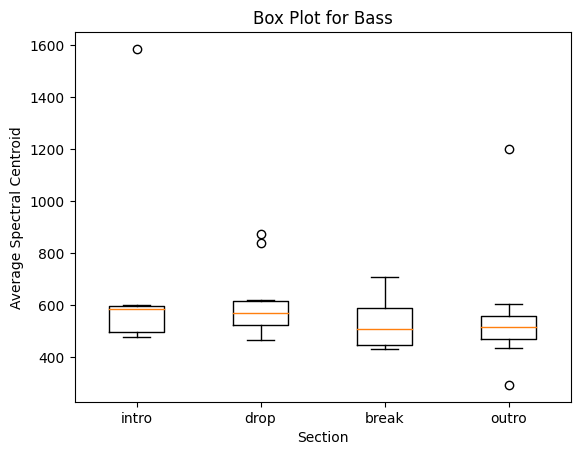

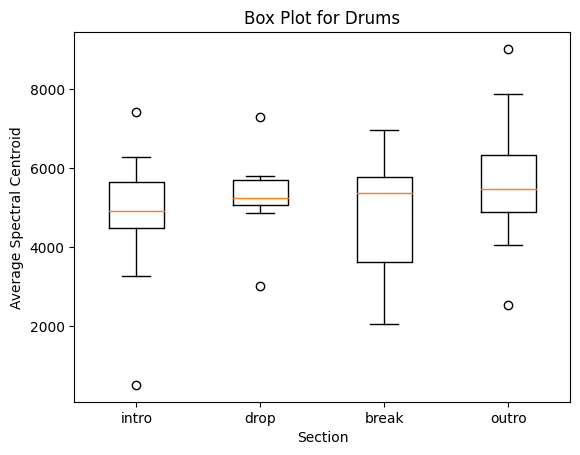

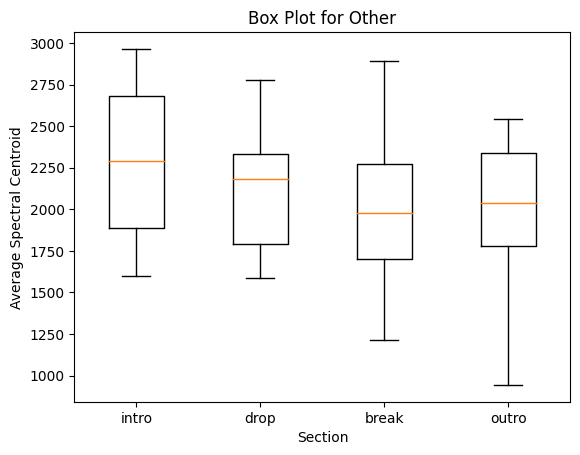

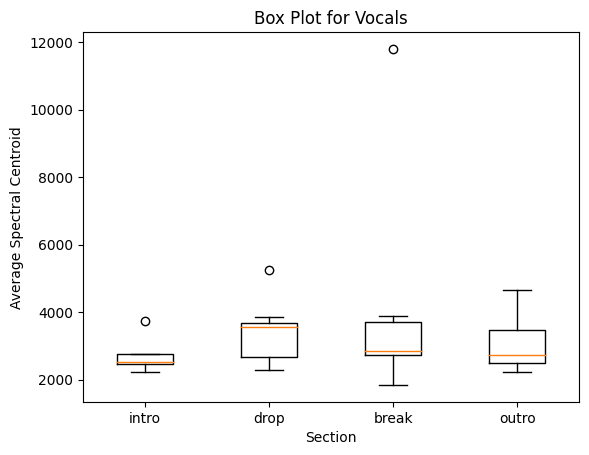

In [ ]:
def calculate_section_averages(sections, spectral_centroid, sr, times):
    section_averages = {'intro': [], 'drop': [], 'break': [], 'outro': []}
    spectral_centroid = spectral_centroid.flatten()

    for section in sections:
        label = section['label']
        if label in section_averages:
            start_index = np.argmax(times >= section['start'])
            end_index = np.argmax(times >= section['end'])
            if end_index == 0:
                end_index = len(spectral_centroid)

            section_centroid = spectral_centroid[start_index:end_index]
            if len(section_centroid) > 0:
                section_average = section_centroid.mean()
                section_averages[label].append(section_average)

    for label in section_averages:
        if section_averages[label]:
            section_averages[label] = sum(section_averages[label]) / len(section_averages[label])
        else:
            section_averages[label] = None

    return section_averages

def calculate_filtered_section_averages(sections, spectral_centroid, sr, times, audio_path, rms_threshold=0.01):
    y, _ = librosa.load(audio_path, sr=None)
    section_averages = {'intro': [], 'drop': [], 'break': [], 'outro': []}
    spectral_centroid = spectral_centroid.flatten()

    for section in sections:
        label = section['label']
        if label in section_averages:
            start_index = np.argmax(times >= section['start'])
            end_index = np.argmax(times >= section['end'])
            if end_index == 0:
                end_index = len(spectral_centroid)

            valid_indices = filter_by_rms(y, sr, start_index, end_index, rms_threshold)
            filtered_centroid = spectral_centroid[start_index:end_index][valid_indices]

            if len(filtered_centroid) > 0:
                section_average = filtered_centroid.mean()
                section_averages[label].append(section_average)

    for label in section_averages:
        if section_averages[label]:
            section_averages[label] = sum(section_averages[label]) / len(section_averages[label])
        else:
            section_averages[label] = None

    return section_averages

def filter_by_rms(y, sr, start_index, end_index, rms_threshold):
    rms = librosa.feature.rms(y=y)[0]
    section_rms = rms[start_index:end_index]
    valid_indices = section_rms >= rms_threshold
    return valid_indices

def plot_bar_graph(section_averages, title):
    total_averages = {section: np.mean([avg for avg in avgs if avg is not None])
                      for section, avgs in section_averages.items()}

    plt.bar(total_averages.keys(), total_averages.values(), alpha=0.5, label='Average per section')
    for section, avgs in section_averages.items():
        plt.scatter([section] * len(avgs), avgs, color='red', alpha=0.6, label='Individual averages' if section == 'intro' else "")

    plt.xlabel('Section')
    plt.ylabel('Average Spectral Centroid')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_combined_bar_graph(component_averages, components):
    colors = ['blue', 'green', 'red', 'purple']
    bar_width = 0.45
    gap_width = 0.25
    group_width = len(components) * bar_width + (len(components) - 1) * gap_width
    positions = np.arange(1, len(components) * 4, 4)

    for i, comp in enumerate(components):
        for j, section in enumerate(['intro', 'drop', 'break', 'outro']):
            data = component_averages[comp][section]
            if data:
                avg = np.mean(data)
                position = positions[j] + i * (bar_width + gap_width)
                plt.bar(position, avg, color=colors[i], width=bar_width, label=comp if j == 0 else "")
                for d in data:
                    plt.scatter(position, d, color=colors[i], edgecolor='black')

    plt.axvline(x=4, color='gray', linestyle='--')
    plt.axvline(x=8, color='gray', linestyle='--')
    plt.axvline(x=12, color='gray', linestyle='--')

    plt.xticks(positions + group_width / 2, ['Intro', 'Drop', 'Break', 'Outro'])
    plt.xlabel('Section')
    plt.ylabel('Average Spectral Centroid')
    plt.title('Combined Bar Graph for Each Component')

    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_box_plot(section_averages, title):
    data_to_plot = [avgs for avgs in section_averages.values()]
    plt.boxplot(data_to_plot, labels=section_averages.keys())
    plt.xlabel('Section')
    plt.ylabel('Average Spectral Centroid')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_violin_plot(section_averages, title):
    data_to_plot = [avgs for avgs in section_averages.values() if avgs]
    plt.violinplot(data_to_plot)
    plt.xticks(range(1, len(section_averages) + 1), section_averages.keys())
    plt.xlabel('Section')
    plt.ylabel('Average Spectral Centroid')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_combined_box_plot(component_averages, components):
    colors = ['blue', 'green', 'red', 'purple']
    positions = np.arange(1, len(components) * 4, 4)

    for i, comp in enumerate(components):
        data = [component_averages[comp][section] for section in ['intro', 'drop', 'break', 'outro'] if component_averages[comp][section]]
        pos = positions + i
        plt.boxplot(data, positions=pos, patch_artist=True, boxprops=dict(facecolor=colors[i]), showmeans=True)

    plt.xticks(positions + 1.5, ['Intro', 'Drop', 'Break', 'Outro'])
    plt.axvline(x=4.5, color='gray', linestyle='--')
    plt.axvline(x=8.5, color='gray', linestyle='--')
    plt.axvline(x=12.5, color='gray', linestyle='--')

    plt.xlabel('Section')
    plt.ylabel('Average Spectral Centroid')
    plt.title('Combined Box Plot for Each Component')

    plt.legend([plt.Line2D([0], [0], color=color, lw=4) for color in colors], components)
    plt.tight_layout()
    plt.show()

def plot_combined_violin_plot(component_averages, components):
    colors = ['blue', 'yellow', 'green', 'red']
    positions = np.arange(1, len(components) * 4, 4)

    for i, comp in enumerate(components):
        data = [component_averages[comp][section] for section in ['intro', 'drop', 'break', 'outro'] if component_averages[comp][section]]
        pos = positions + i
        plt.violinplot(data, positions=pos, showmeans=True, showmedians=True, showextrema=True)

    plt.xticks(positions + 1.5, ['Intro', 'Drop', 'Break', 'Outro'])
    plt.axvline(x=4.5, color='gray', linestyle='--')
    plt.axvline(x=8.5, color='gray', linestyle='--')
    plt.axvline(x=12.5, color='gray', linestyle='--')

    plt.xlabel('Section')
    plt.ylabel('Average Spectral Centroid')
    plt.title('Combined Violin Plot for Each Component')

    plt.legend([plt.Line2D([0], [0], color=color, lw=4) for color in colors], components)
    plt.tight_layout()
    plt.show()

def plot_rms(audio_path, threshold=0.01, title=""):
    y, sr = librosa.load(audio_path, sr=None)
    rms = librosa.feature.rms(y=y)[0]
    times = librosa.times_like(rms, sr=sr)

    plt.figure(figsize=(10, 4))
    plt.plot(times, rms)
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.fill_between(times, rms, threshold, where=rms < threshold, color='red', alpha=0.5)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('RMS')
    plt.legend()
    plt.show()

def process_files(json_directory, song_directory, freq, allin1, component_averages, components):
    for root, dirs, files in tqdm(os.walk(json_directory), desc="Processing files"):
        for file in tqdm(files, desc="Processing file", leave=False):
            if file.endswith(".json"):
                json_path = os.path.join(root, file)
                process_file(json_path, song_directory, freq, component_averages, allin1, components)

def process_file(json_path, song_directory, freq, component_averages, allin1, components):
    section_data = allin1.load_section_data(json_path)
    song_name = os.path.splitext(os.path.basename(json_path))[0]

    for component in components:
        file_path = os.path.join(song_directory, song_name, f"{component}.mp3")
        if os.path.exists(file_path):
            spectral_centroid, sr, times = freq.get_spectral_centroid(file_path)
            section_averages = calculate_filtered_section_averages(
                section_data['segments'], spectral_centroid, sr, times, file_path)

            for section, average in section_averages.items():
                if average is not None:
                    component_averages[component][section].append(average)

def main(process_mode):
    song_directory = PROD_SONG_DIRECTORY
    json_directory = PROD_JSON_DIRECTORY
    demucs_directory = PROD_DEMUCS_DIRECTORY
    freq = Frequency()
    allin1 = Allin1()

    components = ['bass', 'drums', 'other', 'vocals']
    component_averages = {component: {'intro': [], 'drop': [], 'break': [], 'outro': []} for component in components}

    """
    for root, dirs, files in os.walk(json_directory):
        for file in files:
            if file.endswith(".json"):
                song_name = os.path.splitext(file)[0]
                for component in components:
                    file_path = os.path.join(demucs_directory, song_name, f"{component}.mp3")
                    if os.path.exists(file_path):
                        plot_rms(file_path, title=f"{song_name} - {component.capitalize()} RMS Plot")
    """

    process_files(json_directory, demucs_directory, freq, allin1, component_averages, components)

    if process_mode == 'bar':
        for component in components:
            plot_bar_graph(component_averages[component], f"Bar Graph for {component.capitalize()}")
    elif process_mode == 'combined_bar':
        plot_combined_bar_graph(component_averages, components)
    elif process_mode == 'box':
        for component in components:
            plot_box_plot(component_averages[component], f"Box Plot for {component.capitalize()}")
    elif process_mode == 'combined_box':
        plot_combined_box_plot(component_averages, components)
    elif process_mode == 'violin':
        for component in components:
            plot_violin_plot(component_averages[component], f"Violin Plot for {component.capitalize()}")
    elif process_mode == 'combined_violin':
        plot_combined_violin_plot(component_averages, components)


if __name__ == "__main__":
    process_mode = 'combined_bar'  # 'bar' | 'combined_bar' | 'box' | 'combined_box' | 'violin' | 'combined_violin' | 'rms_plot'
    main(process_mode)

### experiment2ex

In [ ]:
def process_files(json_directory, song_directory, freq, allin1, component_averages, components):
    for root, dirs, files in tqdm(os.walk(json_directory), desc="Processing files"):
        for file in tqdm(files, desc="Processing file", leave=False):
            if file.endswith(".json"):
                json_path = os.path.join(root, file)
                process_file(json_path, song_directory, freq, component_averages, allin1, components)

def process_file(json_path, song_directory, freq, component_averages, allin1, components):
    section_data = allin1.load_section_data(json_path)
    song_name = os.path.splitext(os.path.basename(json_path))[0]

    for component in components:
        file_path = os.path.join(song_directory, song_name, f"{component}.mp3")
        if os.path.exists(file_path):
            spectral_centroid, sr, times = freq.get_spectral_centroid(file_path)
            section_averages = calculate_filtered_section_averages(
                section_data['segments'], spectral_centroid, sr, times, file_path)

            for section, average in section_averages.items():
                if average is not None:
                    component_averages[component][section].append(average)

def calculate_section_averages(sections, spectral_centroid, sr, times):
    section_averages = {'intro': [], 'drop': [], 'break': [], 'outro': []}
    spectral_centroid = spectral_centroid.flatten()

    for section in sections:
        label = section['label']
        if label in section_averages:
            start_index = np.argmax(times >= section['start'])
            end_index = np.argmax(times >= section['end'])
            if end_index == 0:
                end_index = len(spectral_centroid)

            section_centroid = spectral_centroid[start_index:end_index]
            if len(section_centroid) > 0:
                section_average = section_centroid.mean()
                section_averages[label].append(section_average)

    for label in section_averages:
        if section_averages[label]:
            section_averages[label] = sum(section_averages[label]) / len(section_averages[label])
        else:
            section_averages[label] = None

    return section_averages

def calculate_filtered_section_averages(sections, spectral_centroid, sr, times, audio_path, rms_threshold=0.01):
    y, _ = librosa.load(audio_path, sr=None)
    section_averages = {'intro': [], 'drop': [], 'break': [], 'outro': []}
    spectral_centroid = spectral_centroid.flatten()

    for section in sections:
        label = section['label']
        if label in section_averages:
            start_index = np.argmax(times >= section['start'])
            end_index = np.argmax(times >= section['end'])
            if end_index == 0:
                end_index = len(spectral_centroid)

            valid_indices = filter_by_rms(y, sr, start_index, end_index, rms_threshold)
            filtered_centroid = spectral_centroid[start_index:end_index][valid_indices]

            if len(filtered_centroid) > 0:
                section_average = filtered_centroid.mean()
                section_averages[label].append(section_average)

    for label in section_averages:
        if section_averages[label]:
            section_averages[label] = sum(section_averages[label]) / len(section_averages[label])
        else:
            section_averages[label] = None

    return section_averages

def filter_by_rms(y, sr, start_index, end_index, rms_threshold):
    rms = librosa.feature.rms(y=y)[0]
    section_rms = rms[start_index:end_index]
    valid_indices = section_rms >= rms_threshold
    return valid_indices

def calculate_filtered_play_time_by_section_and_component(sections, y, sr, rms_threshold):
    section_play_time = {'intro': 0, 'drop': 0, 'break': 0, 'outro': 0}

    for section in sections:
        label = section['label']
        valid_indices = filter_by_rms(y, sr, section['start'], section['end'], rms_threshold)
        play_time = np.sum(valid_indices) / sr
        section_play_time[label] += play_time

    return section_play_time

def filter_by_rms(y, sr, start_time, end_time, rms_threshold):
    rms = librosa.feature.rms(y=y)[0]
    times = librosa.times_like(rms, sr=sr)
    start_index = np.argmax(times >= start_time)
    end_index = np.argmax(times >= end_time)
    if end_index == 0:
        end_index = len(rms)
    valid_indices = rms[start_index:end_index] >= rms_threshold
    return valid_indices

def plot_stack_bar(total_play_times_by_component):
    sections = ['intro', 'drop', 'break', 'outro']
    components = total_play_times_by_component.keys()

    play_times = {component: [total_play_times_by_component[component][section] for section in sections] for component in components}

    fig, ax = plt.subplots()
    bottom = np.zeros(len(components))
    colors = ['yellow', 'red', 'green', 'blue']

    for i, section in enumerate(sections):
        play_time = np.array([play_times[component][sections.index(section)] for component in components])
        ax.bar(components, play_time, bottom=bottom, label=section.capitalize(), color=colors[i])
        bottom += play_time

    ax.set_xlabel('Component')
    ax.set_ylabel('Total Play Time (Seconds)')
    ax.set_title('Total Play Time by Component and Section')
    ax.legend()

    plt.tight_layout()
    plt.show()

def process_file_for_play_time(json_path, song_directory, allin1, components, rms_threshold):
    section_data = allin1.load_section_data(json_path)
    song_name = os.path.splitext(os.path.basename(json_path))[0]
    component_play_times = {component: {'intro': 0, 'drop': 0, 'break': 0, 'outro': 0} for component in components}

    for component in components:
        file_path = os.path.join(song_directory, song_name, f"{component}.mp3")
        if os.path.exists(file_path):
            y, sr = librosa.load(file_path, sr=None)
            section_play_time = calculate_filtered_play_time_by_section_and_component(section_data['segments'], y, sr, rms_threshold)
            for section, time in section_play_time.items():
                component_play_times[component][section] += time

    return component_play_times

def main(process_mode):
    json_directory = PROD_JSON_DIRECTORY
    demucs_directory = PROD_DEMUCS_DIRECTORY
    allin1 = Allin1()
    components = ['bass', 'drums', 'other', 'vocals']
    rms_threshold = 0.01
    total_play_times_by_component = {component: {'intro': 0, 'drop': 0, 'break': 0, 'outro': 0} for component in components}

    total_files = sum([len(files) for r, d, files in os.walk(json_directory) if any(file.endswith(".json") for file in files)])
    progress_bar = tqdm(total=total_files, desc="Processing files")

    for root, dirs, files in os.walk(json_directory):
        for file in files:
            if file.endswith(".json"):
                json_path = os.path.join(root, file)
                play_times = process_file_for_play_time(json_path, demucs_directory, allin1, components, rms_threshold)
                for component, times in play_times.items():
                    for section, time in times.items():
                        total_play_times_by_component[component][section] += time
                progress_bar.update(1)

    progress_bar.close()

    if process_mode == 'stack_bar':
        plot_stack_bar(total_play_times_by_component)

if __name__ == "__main__":
    process_mode = 'stack_bar'
    main(process_mode)

### experiment3

Overall Progress: 100%|██████████| 11/11 [00:27<00:00,  2.46s/it]


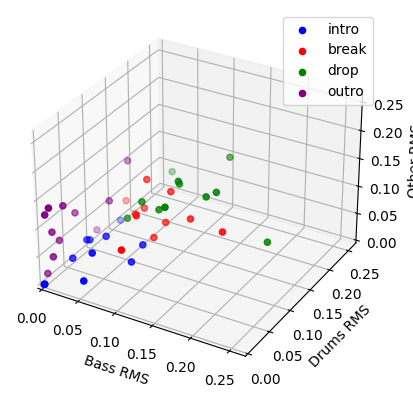

In [ ]:
def calculate_section_rms(y, sr, sections):
    rms_values = {}
    for section in sections:
        start_frame = librosa.time_to_samples(section['start'], sr=sr)
        end_frame = librosa.time_to_samples(section['end'], sr=sr)
        rms = librosa.feature.rms(y=y[start_frame:end_frame]).mean()
        if section['label'] not in rms_values:
            rms_values[section['label']] = []
        rms_values[section['label']].append(rms)
    return rms_values

def combine_audio_files(file1_path, file2_path):
    sound1 = AudioSegment.from_file(file1_path)
    sound2 = AudioSegment.from_file(file2_path)
    combined = sound1.overlay(sound2)
    return np.array(combined.get_array_of_samples(), dtype=np.float32) / (2**15)

def calculate_rms_for_part(part, demucs_directory, song_name, section_data):
    if part == 'other':
        other_path = os.path.join(demucs_directory, song_name, 'other.mp3')
        vocals_path = os.path.join(demucs_directory, song_name, 'vocals.mp3')
        y = combine_audio_files(other_path, vocals_path)
        sr = 44100
    else:
        file_path = os.path.join(demucs_directory, song_name, f"{part}.mp3")
        y, sr = librosa.load(file_path, sr=None)

    return calculate_section_rms(y, sr, section_data['segments'])

def find_max_rms(all_rms_values):
    max_rms = 0
    for section in all_rms_values:
        for part in ['bass', 'drums', 'other']:
            max_rms = max(max_rms, max(all_rms_values[section][part]))
    return max_rms

def plot_3d_rms(all_rms_values, max_rms):
    fig = plt.figure(figsize=(12, 8))

    for i, (section, rms_values) in enumerate(all_rms_values.items(), 1):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        ax.scatter(rms_values['bass'], rms_values['drums'], rms_values['other'], s=5)
        ax.set_xlabel('Bass RMS')
        ax.set_ylabel('Drums RMS')
        ax.set_zlabel('Other RMS')
        ax.set_xlim([0, max_rms])
        ax.set_ylim([0, max_rms])
        ax.set_zlim([0, max_rms])
        ax.set_title(f"Section: {section}")

    plt.tight_layout()
    plt.show()

def plot_3d_rms_combined(all_rms_values, max_rms):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    colors = {'intro': 'orange', 'drop': 'red', 'break': 'green', 'outro': 'blue'}
    for section, rms_values in all_rms_values.items():
        color = colors[section]
        ax.scatter(rms_values['bass'], rms_values['drums'], rms_values['other'], c=color, label=section, s=5, alpha=0.5)

    ax.set_xlabel('Bass RMS')
    ax.set_ylabel('Drums RMS')
    ax.set_zlabel('Other RMS')
    ax.set_xlim([0, max_rms])
    ax.set_ylim([0, max_rms])
    ax.set_zlim([0, max_rms])
    ax.legend()
    plt.tight_layout()
    plt.show()

def process_file(json_path, demucs_directory, allin1, all_rms_values, song_section_rms):
    section_data = allin1.load_section_data(json_path)
    song_name = os.path.splitext(os.path.basename(json_path))[0]

    song_rms_values = {'bass': {}, 'drums': {}, 'other': {}}
    for part in tqdm(song_rms_values, desc=f"Processing parts for {song_name}", leave=False):
        rms = calculate_rms_for_part(part, demucs_directory, song_name, section_data)
        for label, values in rms.items():
            if label not in all_rms_values:
                all_rms_values[label] = {'bass': [], 'drums': [], 'other': []}
                song_section_rms[label] = []
            all_rms_values[label][part].append(np.mean(values))
            song_section_rms[label].append(f"Song: {song_name}, Section: {label}, Part: {part}, RMS: {np.mean(values)}")

def main(plot_mode):
    json_directory = PROD_JSON_DIRECTORY
    demucs_directory = PROD_DEMUCS_DIRECTORY
    allin1 = Allin1()
    all_rms_values = {}
    song_section_rms = {}

    total_files = sum([len(files) for r, d, files in os.walk(json_directory) if any(file.endswith(".json") for file in files)])
    progress_bar = tqdm(total=total_files, desc="Overall Progress")

    for root, dirs, files in os.walk(json_directory):
        for file in files:
            if file.endswith(".json"):
                json_path = os.path.join(root, file)
                process_file(json_path, demucs_directory, allin1, all_rms_values, song_section_rms)
                progress_bar.update(1)

    progress_bar.close()

    max_rms = find_max_rms(all_rms_values)

    if plot_mode == 'separate':
        plot_3d_rms(all_rms_values, max_rms)
    elif plot_mode == 'combined':
        plot_3d_rms_combined(all_rms_values, max_rms)

if __name__ == "__main__":
    plot_mode = 'separate'  # 'separate' | 'combined'
    main(plot_mode)


### experiment4

Overall Progress: 100%|██████████| 11/11 [00:00<00:00, 18.93it/s]


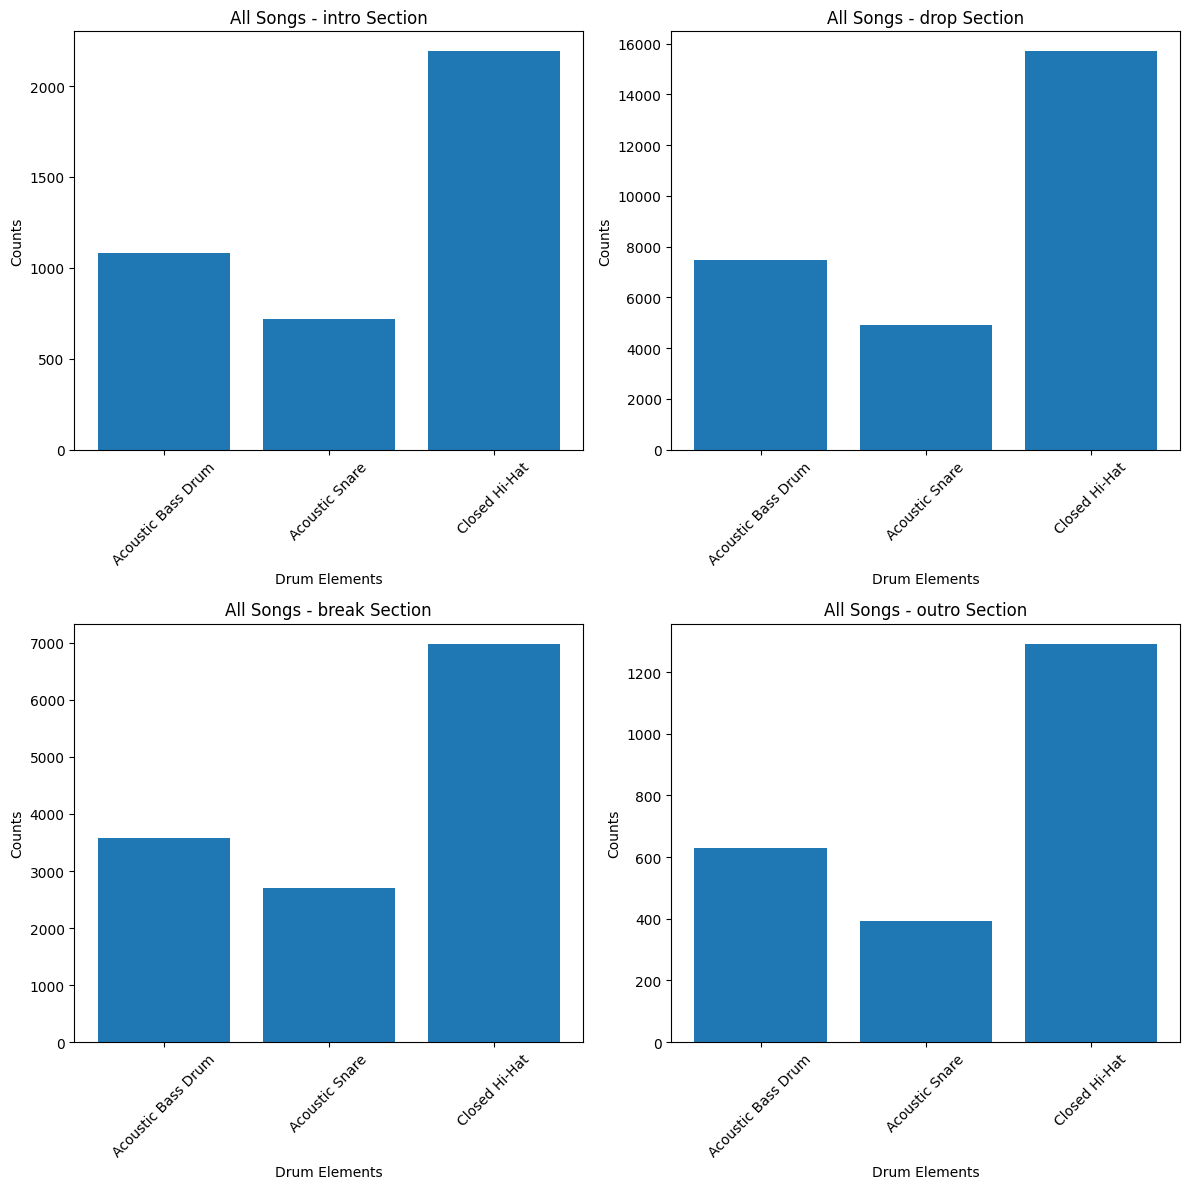

In [ ]:
def process_midi_file_single(midi_path, section_data, drum_mapping):
    drum = Drum(midi_path)
    drum_events = drum.get_drum_events()
    section_counts = {section['label']: {name: 0 for name in drum_mapping.values()} for section in section_data['segments']}

    existing_drums = set()
    for note, event in drum_events.items():
        drum_name = event['name']
        existing_drums.add(drum_name)
        for time in event['times']:
            for section in section_data['segments']:
                if section['start'] <= time < section['end']:
                    section_counts[section['label']][drum_name] += 1
                    break

    return section_counts, existing_drums

def process_midi_file_combined(midi_path, section_data, drum_mapping, all_section_counts, all_existing_drums):
    drum = Drum(midi_path)
    drum_events = drum.get_drum_events()

    existing_drums = set()
    section_counts = {'intro': {}, 'drop': {}, 'break': {}, 'outro': {}}

    for note, event in drum_events.items():
        drum_name = event['name']
        existing_drums.add(drum_name)
        for time in event['times']:
            for section in section_data['segments']:
                if section['start'] <= time < section['end']:
                    if drum_name in section_counts[section['label']]:
                        section_counts[section['label']][drum_name] += 1
                    else:
                        section_counts[section['label']][drum_name] = 1
                    break

    for section, counts in section_counts.items():
        if section not in all_section_counts:
            all_section_counts[section] = {}
        for drum, count in counts.items():
            if drum in all_section_counts[section]:
                all_section_counts[section][drum] += count
            else:
                all_section_counts[section][drum] = count

    all_existing_drums.update(existing_drums)

def plot_drum_section_counts(song_name, section_counts, existing_drums):
    num_sections = len(section_counts)
    num_cols = 2
    num_rows = np.ceil(num_sections / num_cols).astype(int)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, (section, counts) in enumerate(section_counts.items()):
        if i < len(axes):
            ax = axes[i]
            filtered_counts = {k: v for k, v in counts.items() if k in existing_drums}
            ax.bar(range(len(filtered_counts)), list(filtered_counts.values()), tick_label=list(filtered_counts.keys()))
            ax.set_title(f"{song_name} - {section} Section")
            ax.set_xlabel("Drum Elements")
            ax.set_ylabel("Counts")
            ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def process_file(json_path, midi_directory, allin1, all_section_counts, all_existing_drums, process_mode):
    midi_path = os.path.join(midi_directory, os.path.splitext(os.path.basename(json_path))[0] + '.mid')
    if not os.path.exists(midi_path):
        return

    song_name = os.path.splitext(os.path.basename(json_path))[0]
    section_data = allin1.load_section_data(json_path)

    if process_mode == 'single':
        section_counts, existing_drums = process_midi_file_single(midi_path, section_data, Drum(midi_path).drum_mapping)
        plot_drum_section_counts(song_name, section_counts, existing_drums)
    elif process_mode == 'combined':
        process_midi_file_combined(midi_path, section_data, Drum(midi_path).drum_mapping, all_section_counts, all_existing_drums)

def plot_combined_drum_section_counts(all_section_counts, all_existing_drums):
    num_sections = len(all_section_counts)
    num_cols = 2
    num_rows = np.ceil(num_sections / num_cols).astype(int)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, (section, counts) in enumerate(all_section_counts.items()):
        if i < len(axes):
            ax = axes[i]
            filtered_counts = {k: v for k, v in counts.items() if k in all_existing_drums}
            ax.bar(range(len(filtered_counts)), list(filtered_counts.values()), tick_label=list(filtered_counts.keys()))
            ax.set_title(f"All Songs - {section} Section")
            ax.set_xlabel("Drum Elements")
            ax.set_ylabel("Counts")
            ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def main(process_mode):
    json_directory = PROD_JSON_DIRECTORY
    midi_directory = PROD_MIDI_DIRECTORY
    allin1 = Allin1()

    all_section_counts = {'intro': {}, 'drop': {}, 'break': {}, 'outro': {}}
    all_existing_drums = set()

    total_files = sum([len(files) for r, d, files in os.walk(json_directory) if any(file.endswith(".json") for file in files)])
    progress_bar = tqdm(total=total_files, desc="Overall Progress")

    for root, dirs, files in os.walk(json_directory):
        for file in files:
            if file.endswith(".json"):
                json_path = os.path.join(root, file)
                process_file(json_path, midi_directory, allin1, all_section_counts, all_existing_drums, process_mode)
                progress_bar.update(1)

    progress_bar.close()

    if process_mode == 'combined':
        plot_combined_drum_section_counts(all_section_counts, all_existing_drums)

if __name__ == "__main__":
    process_mode = 'combined'  # 'single' or 'combined'
    main(process_mode)

### experiment4ex

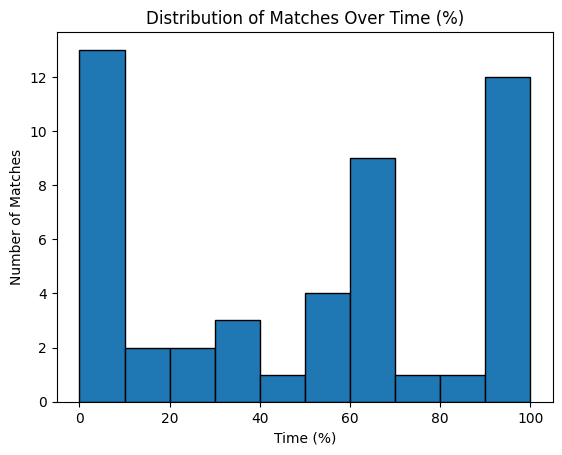

In [ ]:
def plot_spaghetti(drum_times_all_songs, drum_mapping):
    target_drums = set(['Acoustic Bass Drum', 'Acoustic Snare', 'Closed Hi-Hat'])
    common_color = 'blue'
    alpha_value = 0.1

    for drum, songs_times in drum_times_all_songs.items():
        if drum not in target_drums:
            continue

        plt.figure(figsize=(10, 6))
        for song, times in songs_times.items():
            times_sorted = sorted(times)
            plt.plot(times_sorted, range(len(times_sorted)), label=song, marker='o', linestyle='-', markersize=0.01,
                     color=common_color, alpha=alpha_value)
        plt.title(f"Drum Events for {drum}")
        plt.xlabel("Time (s)")
        plt.ylabel("Number of Events")
        plt.tight_layout()
        plt.show()

def process_midi_file(midi_path, section_data, drum_mapping):
    drum = Drum(midi_path)
    drum_events = drum.get_drum_events()
    section_counts = {section['label']: {name: 0 for name in drum_mapping.values()} for section in section_data['segments']}

    existing_drums = set()
    drum_times = {drum_name: [] for drum_name in drum_mapping.values()}
    for note, event in drum_events.items():
        drum_name = event['name']
        existing_drums.add(drum_name)
        drum_times[drum_name].extend(event['times'])
        for time in event['times']:
            for section in section_data['segments']:
                if section['start'] <= time < section['end']:
                    section_counts[section['label']][drum_name] += 1
                    break

    return section_counts, existing_drums, drum_times

def process_file(json_path, midi_directory, allin1, all_section_counts, all_existing_drums, drum_times_all_songs):
    base_name = os.path.splitext(os.path.basename(json_path))[0]
    midi_path = os.path.join(midi_directory, base_name + '.mid')
    if not os.path.exists(midi_path):
        return

    song_name = base_name

    section_data = allin1.load_section_data(json_path)
    section_counts, existing_drums, drum_times = process_midi_file(midi_path, section_data, Drum(midi_path).drum_mapping)
    for drum, times in drum_times.items():
        drum_times_all_songs[drum][song_name].extend(times)


def main():
    json_directory = PROD_JSON_DIRECTORY
    midi_directory = PROD_MIDI_DIRECTORY
    allin1 = Allin1()

    all_section_counts = {'intro': {}, 'drop': {}, 'break': {}, 'outro': {}}
    all_existing_drums = set()
    drum_times_all_songs = defaultdict(lambda: defaultdict(list))

    total_files = sum([len(files) for r, d, files in os.walk(json_directory) if any(file.endswith(".json") for file in files)])
    progress_bar = tqdm(total=total_files, desc="Overall Progress")

    for root, dirs, files in os.walk(json_directory):
        for file in files:
            if file.endswith(".json"):
                json_path = os.path.join(root, file)
                process_file(json_path, midi_directory, allin1, all_section_counts, all_existing_drums, drum_times_all_songs)
                song_name = os.path.splitext(file)[0]
                midi_path = os.path.join(midi_directory, song_name + '.mid')
                if not os.path.exists(midi_path):
                    continue
                section_data = allin1.load_section_data(json_path)
                _, _, drum_times = process_midi_file(midi_path, section_data, Drum(midi_path).drum_mapping)

                for drum, times in drum_times.items():
                    drum_times_all_songs[drum][song_name].extend(times)

                progress_bar.update(1)

    progress_bar.close()

    plot_spaghetti(drum_times_all_songs, Drum(midi_directory).drum_mapping)

if __name__ == "__main__":
    main()

### experiment4ex2

In [ ]:
def calculate_bar_length(bpm):
    beats_per_bar = 4
    bars = 8
    beats_per_minute = bpm
    seconds_per_beat = 60.0 / beats_per_minute
    bar_length = seconds_per_beat * beats_per_bar * bars
    return bar_length

def get_bpm_from_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data['bpm']

def count_drum_events_in_bars(drum_times, bar_length):
    bar_counts = defaultdict(int)
    for time in drum_times:
        bar_index = int(time // bar_length)
        bar_counts[bar_index] += 1
    return bar_counts

def plot_spaghetti(drum_counts_per_bar_all_songs, note_to_drum):
    for drum_note, songs_bar_counts in drum_counts_per_bar_all_songs.items():
        drum_name = note_to_drum.get(drum_note, drum_note)
        plt.figure(figsize=(10, 6))
        for song, bar_counts in songs_bar_counts.items():
            bars = sorted(bar_counts.keys())
            counts = [bar_counts[bar] for bar in bars]
            plt.plot(bars, counts, label=song, marker='o', linestyle='-', markersize=0.01, alpha=0.1, color='blue')
        plt.title(f"Drum Events per 8 Bars for {drum_name}")
        plt.xlabel("8 Bar Sections")
        plt.ylabel("Number of Events")
        plt.tight_layout()
        plt.show()

def process_file(json_path, midi_directory, drum_mapping, drum_counts_per_bar_all_songs):
    base_name = os.path.splitext(os.path.basename(json_path))[0]
    midi_path = os.path.join(midi_directory, base_name + '.mid')
    if not os.path.exists(midi_path):
        return

    bpm = get_bpm_from_json(json_path)
    bar_length = calculate_bar_length(bpm)

    drum = Drum(midi_path)
    drum_events = drum.get_drum_events()

    '''
    pprint.pprint(base_name)
    print('Acoustic Bass Drum', len(drum_events[35]['times']))
    print('Acoustic Snare', len(drum_events[38]['times']))
    print('Closed Hi-Hat', len(drum_events[42]['times']))
    '''

    for drum_name in drum_mapping.values():
        if drum_name in drum_events:
            drum_times = drum_events[drum_name]['times']
            bar_counts = count_drum_events_in_bars(drum_times, bar_length)
            drum_counts_per_bar_all_songs[drum_name][base_name] = bar_counts

def main():
    json_directory = PROD_JSON_DIRECTORY_TEMPO
    midi_directory = PROD_MIDI_DIRECTORY
    drum_mapping = {'Acoustic Bass Drum': 35, 'Acoustic Snare': 38, 'Closed Hi-Hat': 42}
    note_to_drum = {note: drum for drum, note in drum_mapping.items()}

    drum_counts_per_bar_all_songs = defaultdict(lambda: defaultdict(dict))

    total_files = sum([len(files) for r, d, files in os.walk(json_directory) if any(file.endswith(".json") for file in files)])
    progress_bar = tqdm(total=total_files, desc="Overall Progress")

    for root, dirs, files in os.walk(json_directory):
        for file in files:
            if file.endswith(".json"):
                json_path = os.path.join(root, file)
                process_file(json_path, midi_directory, drum_mapping, drum_counts_per_bar_all_songs)
                progress_bar.update(1)

    progress_bar.close()
    plot_spaghetti(drum_counts_per_bar_all_songs, note_to_drum)

if __name__ == "__main__":
    main()

### experiment5

In [ ]:
def calculate_section_based_matching_rate(pattern_changes, section_changes, song_duration):
    matched_count = 0
    matched_times_percent = []

    for section_change in section_changes:
        if any(section_change - 1 <= pattern_change <= section_change + 1 for pattern_change in pattern_changes):
            matched_count += 1
            matched_percent = (section_change / song_duration) * 100
            matched_times_percent.append(matched_percent)

    matching_rate = (matched_count / len(section_changes)) * 100 if section_changes else 0
    return matching_rate, matched_times_percent


def calculate_drum_based_matching_rate(pattern_changes, section_changes, song_duration):
    matched_count = 0
    matched_times_percent = []

    for pattern_change in pattern_changes:
        if any(pattern_change - 1 <= section_change <= pattern_change + 1 for section_change in section_changes):
            matched_count += 1
            matched_percent = (pattern_change / song_duration) * 100
            matched_times_percent.append(matched_percent)

    matching_rate = (matched_count / len(pattern_changes)) * 100
    return matching_rate, matched_times_percent

def plot_matching_rates(all_matching_rates):
    plt.hist(all_matching_rates, bins=range(0, 101, 10), histtype="bar", edgecolor="black")
    plt.xlabel('Matching Rate (%)')
    plt.ylabel('Number of Songs')
    plt.title('Distribution of Matching Rates')
    plt.tight_layout()
    plt.show()

def plot_matched_times_percent(matched_times_percent):
    plt.hist(matched_times_percent, bins=range(0, 101, 10), histtype="bar", edgecolor="black")
    plt.xlabel('Time (%)')
    plt.ylabel('Number of Matches')
    plt.title('Distribution of Matches Over Time (%)')
    plt.tight_layout()
    plt.show()

def detect_section_changes(section_data):
    previous_label = None
    section_changes = []
    for segment in section_data['segments']:
        if segment['label'] != previous_label:
            section_changes.append(int(round(segment['start'])))
            previous_label = segment['label']
    return sorted(set(section_changes))

def process_midi_file(midi_path, json_directory, allin1, all_matching_rates, all_matched_times_percent):
    song_name = os.path.splitext(os.path.basename(midi_path))[0]
    json_path = os.path.join(json_directory, f"{song_name}.json")
    section_data = allin1.load_section_data(json_path)

    drum = Drum(midi_path)
    events = drum.get_drum_events()

    events_with_times = {note: event for note, event in events.items() if event['times']}
    if not events_with_times:
        print(f"No drum events found in {song_name}. Skipping.")
        return

    pattern_changes = drum.detect_pattern_changes(events)
    section_changes = detect_section_changes(section_data)

    song_duration = max(max(event['times']) for event in events.values())
    # matching_rate, matched_times_percent = calculate_drum_based_matching_rate(pattern_changes, section_changes, song_duration)
    matching_rate, matched_times_percent = calculate_section_based_matching_rate(pattern_changes, section_changes, song_duration)

    if all_matching_rates is not None:
        all_matching_rates.append(matching_rate)
    if all_matched_times_percent is not None:
        all_matched_times_percent.extend(matched_times_percent)

    # drum.plot_drum_with_pattern_and_sections(song_name, events, pattern_changes, section_changes)

from tqdm import tqdm

def main(process_mode):
    midi_directory = PROD_MIDI_DIRECTORY
    json_directory = PROD_JSON_DIRECTORY
    allin1 = Allin1()

    midi_files = [os.path.join(root, file) for root, dirs, files in os.walk(midi_directory) for file in files if file.endswith(".mid")]
    progress_bar = tqdm(total=len(midi_files), desc="Processing MIDI Files")

    if process_mode == 'timeseries':
        all_matched_times_percent = []
        for midi_path in midi_files:
            process_midi_file(midi_path, json_directory, allin1, None, all_matched_times_percent)
            progress_bar.update(1)
        plot_matched_times_percent(all_matched_times_percent)
    elif process_mode == 'distribution':
        all_matching_rates = []
        for midi_path in midi_files:
            process_midi_file(midi_path, json_directory, allin1, all_matching_rates, None)
            progress_bar.update(1)
        plot_matching_rates(all_matching_rates)

    progress_bar.close()

if __name__ == "__main__":
    process_mode = 'timeseries'  # 'timeseries' | 'distribution'
    main(process_mode)

NameError: name 'PROD_MIDI_DIRECTORY' is not defined